In [1]:
import pandas as pd
import ast
from json import loads, dumps
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bible = []

with open('./kjv.json') as f:
    for line in f:
        bible.append(ast.literal_eval(line.strip()))

In [3]:
bible_df = pd.DataFrame(bible)
bible_df = bible_df[['book_id', 'chapter', 'verse']]

book_order = list(bible_df['book_id'].unique())

bible_df = bible_df.groupby(['book_id','chapter'], as_index=False)['verse'].count()

def book_sorter(column):
    correspondence = {team: order for order, team in enumerate(book_order)}
    return column.map(correspondence)

bible_df = bible_df.sort_values(by=['book_id', 'chapter'], key=book_sorter).reset_index(drop=True)  
bible_dict = bible_df.to_dict('records')
bible_dict

[{'book_id': 'Gen', 'chapter': 1, 'verse': 31},
 {'book_id': 'Gen', 'chapter': 2, 'verse': 25},
 {'book_id': 'Gen', 'chapter': 3, 'verse': 24},
 {'book_id': 'Gen', 'chapter': 4, 'verse': 26},
 {'book_id': 'Gen', 'chapter': 5, 'verse': 32},
 {'book_id': 'Gen', 'chapter': 6, 'verse': 22},
 {'book_id': 'Gen', 'chapter': 7, 'verse': 24},
 {'book_id': 'Gen', 'chapter': 8, 'verse': 22},
 {'book_id': 'Gen', 'chapter': 9, 'verse': 29},
 {'book_id': 'Gen', 'chapter': 10, 'verse': 32},
 {'book_id': 'Gen', 'chapter': 11, 'verse': 32},
 {'book_id': 'Gen', 'chapter': 12, 'verse': 20},
 {'book_id': 'Gen', 'chapter': 13, 'verse': 18},
 {'book_id': 'Gen', 'chapter': 14, 'verse': 24},
 {'book_id': 'Gen', 'chapter': 15, 'verse': 21},
 {'book_id': 'Gen', 'chapter': 16, 'verse': 16},
 {'book_id': 'Gen', 'chapter': 17, 'verse': 27},
 {'book_id': 'Gen', 'chapter': 18, 'verse': 33},
 {'book_id': 'Gen', 'chapter': 19, 'verse': 38},
 {'book_id': 'Gen', 'chapter': 20, 'verse': 18},
 {'book_id': 'Gen', 'chapter'

In [4]:
days = int(365 * (6/7))
print(f"Number of days (w/ weekly day-off): {days}")

total_verses = bible_df['verse'].sum()
print(f"Total verses in Bible: {total_verses}")

total_chapters = len(bible_dict)
print(f"Total chapters in Bible: {total_chapters}")

verses_per_day = int(total_verses / days)
print(f"Verses per day: {verses_per_day}")

chapters_per_day = int(total_chapters / days)
print(f"Chapters per day: {chapters_per_day}")

Number of days (w/ weekly day-off): 312
Total verses in Bible: 31102
Total chapters in Bible: 1189
Verses per day: 99
Chapters per day: 3


Text(0.5, 0, 'Verse distribution')

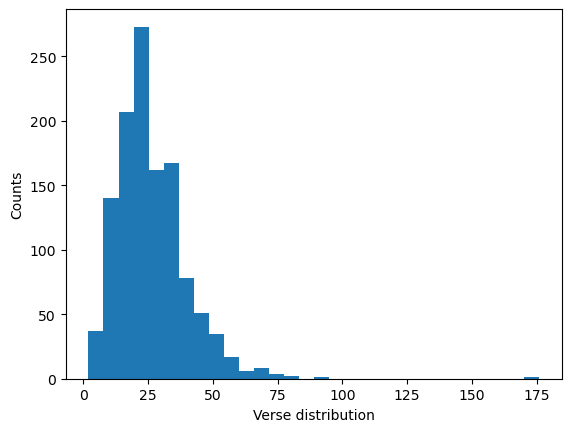

In [5]:
plt.hist(bible_df['verse'], density=False, bins=30)
plt.ylabel('Counts')
plt.xlabel('Verse distribution')

In [6]:
# Iteration 1: Split chapters directly by day

bible_splits = np.array_split(bible_dict, days)
sum_list = []

for item in bible_splits:
    summ = 0
    for verse in item:
        summ += verse['verse']
    sum_list.append(summ)
    
assert len(sum_list) == days

Text(0.5, 0, 'Verses by day')

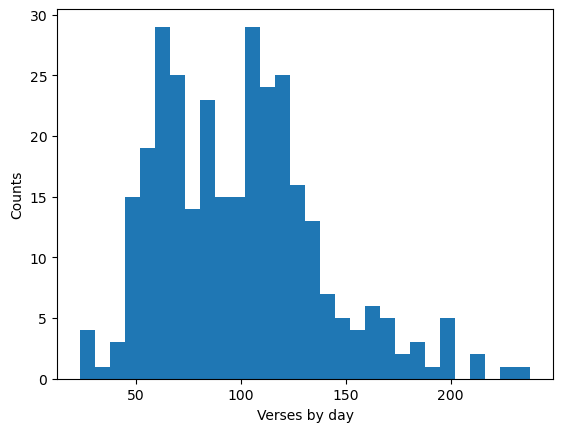

In [7]:
plt.hist(sum_list, density=False, bins=30)
plt.ylabel('Counts')
plt.xlabel('Verses by day')

In [41]:
verses_per_day = 100

In [42]:
# Iteration 2: Split chapters by verse count as close as possible to daily average

bible_splits = [list(i) for i in bible_splits]
bible_splits_sum = [{'split': split, 'sum': sum_list[index]} for index, split in enumerate(bible_splits)]

bible_split = []
bible_split_indexes = []

for curr_ind, curr_chapter in enumerate(bible_dict):
    #print("= = = = = = = = = = = = = = = =")
    #print(curr_ind)
    #print(bible_split)
    #print(bible_split_indexes)
    if curr_ind not in bible_split_indexes:
        curr_split = [curr_chapter]
        bible_split_indexes.append(curr_ind)

        for next_ind, next_chapter in enumerate(bible_dict[curr_ind + 1:]): # loop through all subsequent chapters
            curr_split_verse_sum = sum([i['verse'] for i in curr_split])
            next_split = curr_split + [bible_dict[curr_ind + next_ind + 1]]
            next_split_verse_sum = sum([i['verse'] for i in next_split])
            #print(curr_ind + next_ind + 1)
            if curr_ind + next_ind + 1 == len(bible_dict) - 1: # for last chapter in list, close out
                #print("Reached last item")
                bible_split.append(curr_split)
                break
            elif (next_split_verse_sum - verses_per_day > verses_per_day - curr_split_verse_sum):
                # if next split verse count diff from average is larger than previous split
                #print("Too many new verses - stop adding chapters")
                bible_split.append(curr_split)
                #print(bible_split)
                break # do not add split, keep current_split as is and exit
            else:
                #print(f"Add another split with index {curr_ind + next_ind + 1}")
                #print(f"next_split: {next_split_verse_sum - verses_per_day} - curr_split: {verses_per_day - curr_split_verse_sum}")
                bible_split_indexes.append(curr_ind + next_ind + 1)
                curr_split = next_split
                continue # Add another split
    #else:
        #print(f"Chapter index {curr_ind} skipped")

In [43]:
print(f"{len(bible_split)} splits generated")

313 splits generated


In [11]:
verse_sums = []
for i in bible_split:
    summ = sum([j['verse'] for j in i])
    verse_sums.append(summ)

Text(0.5, 0, 'Verses by day')

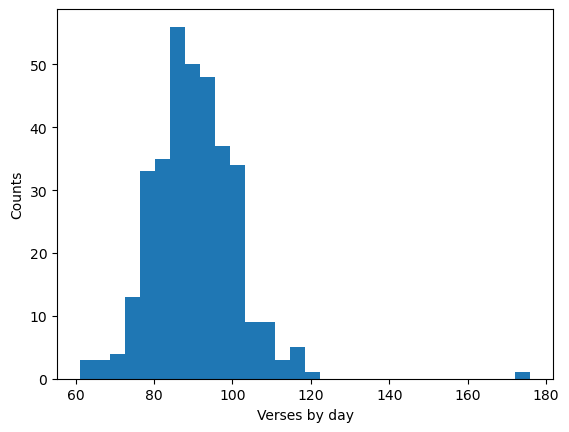

In [12]:
plt.hist(verse_sums, density=False, bins=30)
plt.ylabel('Counts')
plt.xlabel('Verses by day')